In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import RobustScaler
from predict import extract_features


In [2]:
# training parameters
epochs = 20
batch_size = 16
loss = tf.keras.losses.MeanAbsoluteError()
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.99)
# opt = tf.keras.optimizers.Adam()
input_path = '../../data/simulated_1d/'
output_path = './model/'


In [3]:
# load data
x_train = pickle.load(open(input_path+'/train/input_data.pkl', 'rb'))
y_train = pickle.load(open(input_path+'/train/target_data.pkl', 'rb'))
sizes_train = pickle.load(open(input_path+'/train/sizes.pkl', 'rb'))
x_val = pickle.load(open(input_path+'/val/input_data.pkl', 'rb'))
y_val = pickle.load(open(input_path+'/val/target_data.pkl', 'rb'))
sizes_val = pickle.load(open(input_path+'/val/sizes.pkl', 'rb'))


In [4]:
# extract features
x_train = [extract_features(i) for i in x_train]
x_train = np.array(x_train).squeeze()
x_val = [extract_features(i) for i in x_val]
x_val = np.array(x_val).squeeze()


In [5]:
# add reference fraction prediction
y_train = np.array(y_train)
y_train = np.hstack([
    y_train, 
    np.array([i[0]/sum(i) for i in sizes_train]).reshape(-1, 1)
])

y_val = np.array(y_val)
y_val = np.hstack([
    y_val, 
    np.array([i[0]/sum(i) for i in sizes_val]).reshape(-1, 1)
])


In [6]:
# standardize outputs
scalery = RobustScaler()

y_train = scalery.fit_transform(y_train)
y_val = scalery.transform(y_val)


In [7]:
x_train = x_train[..., np.newaxis]
x_val = x_val[..., np.newaxis]


In [8]:
x_train.shape


(8000, 100, 1)

In [9]:
# define model

inputs = tf.keras.layers.Input(shape=x_train.shape[1:])
x = tf.keras.layers.Conv1D(32, kernel_size=10, activation='relu')(inputs)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(64, kernel_size=10, activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(64, kernel_size=10, activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
o = tf.keras.layers.Dense(y_val.shape[1], activation='linear')(x)
model = tf.keras.models.Model(inputs, o)

# define loss and optimizer
model.compile(loss = loss,
              optimizer = opt)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 91, 32)            352       
                                                                 
 max_pooling1d (MaxPooling1  (None, 45, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 36, 64)            20544     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 18, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 9, 64)             41024 

In [10]:
# plot model

# !pip install pydot
# !pip install graphviz

# tf.keras.utils.plot_model(
#     model,
#     to_file="model.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=False,
# )


In [11]:
# define best model checkpoint
checkpoint_path = output_path+'/model_checkpoint'
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_format='tf',
    verbose=1
)

# train
history = model.fit(
    x_train, 
    y_train,
    validation_data = (x_val, y_val),
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [checkpoint_callback],
    verbose = 2
)

with open(output_path+'/model_history.npy', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    

Epoch 1/20


I0000 00:00:1726646506.956682   19907 service.cc:145] XLA service 0x7f7f568a6450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726646506.956722   19907 service.cc:153]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
I0000 00:00:1726646507.728036   19907 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 0.36342, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


500/500 - 27s - loss: 0.4758 - val_loss: 0.3634 - 27s/epoch - 54ms/step
Epoch 2/20

Epoch 2: val_loss improved from 0.36342 to 0.33032, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


500/500 - 2s - loss: 0.3792 - val_loss: 0.3303 - 2s/epoch - 4ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.33032 to 0.31612, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


500/500 - 2s - loss: 0.3487 - val_loss: 0.3161 - 2s/epoch - 4ms/step
Epoch 4/20

Epoch 4: val_loss improved from 0.31612 to 0.29594, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


500/500 - 2s - loss: 0.3261 - val_loss: 0.2959 - 2s/epoch - 4ms/step
Epoch 5/20

Epoch 5: val_loss improved from 0.29594 to 0.29172, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


500/500 - 2s - loss: 0.3141 - val_loss: 0.2917 - 2s/epoch - 4ms/step
Epoch 6/20

Epoch 6: val_loss improved from 0.29172 to 0.27503, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


500/500 - 2s - loss: 0.3065 - val_loss: 0.2750 - 2s/epoch - 4ms/step
Epoch 7/20

Epoch 7: val_loss improved from 0.27503 to 0.27007, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


500/500 - 2s - loss: 0.2954 - val_loss: 0.2701 - 2s/epoch - 4ms/step
Epoch 8/20

Epoch 8: val_loss did not improve from 0.27007
500/500 - 1s - loss: 0.2936 - val_loss: 0.2761 - 1s/epoch - 2ms/step
Epoch 9/20

Epoch 9: val_loss improved from 0.27007 to 0.26397, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


500/500 - 2s - loss: 0.2853 - val_loss: 0.2640 - 2s/epoch - 4ms/step
Epoch 10/20

Epoch 10: val_loss improved from 0.26397 to 0.26102, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


500/500 - 2s - loss: 0.2808 - val_loss: 0.2610 - 2s/epoch - 4ms/step
Epoch 11/20

Epoch 11: val_loss did not improve from 0.26102
500/500 - 1s - loss: 0.2798 - val_loss: 0.2616 - 1s/epoch - 2ms/step
Epoch 12/20

Epoch 12: val_loss did not improve from 0.26102
500/500 - 1s - loss: 0.2769 - val_loss: 0.2663 - 1s/epoch - 2ms/step
Epoch 13/20

Epoch 13: val_loss improved from 0.26102 to 0.25137, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


500/500 - 2s - loss: 0.2776 - val_loss: 0.2514 - 2s/epoch - 4ms/step
Epoch 14/20

Epoch 14: val_loss did not improve from 0.25137
500/500 - 1s - loss: 0.2704 - val_loss: 0.2597 - 1s/epoch - 2ms/step
Epoch 15/20

Epoch 15: val_loss did not improve from 0.25137
500/500 - 1s - loss: 0.2692 - val_loss: 0.2570 - 1s/epoch - 2ms/step
Epoch 16/20

Epoch 16: val_loss did not improve from 0.25137
500/500 - 1s - loss: 0.2651 - val_loss: 0.2518 - 1s/epoch - 2ms/step
Epoch 17/20

Epoch 17: val_loss did not improve from 0.25137
500/500 - 1s - loss: 0.2646 - val_loss: 0.2536 - 1s/epoch - 2ms/step
Epoch 18/20

Epoch 18: val_loss improved from 0.25137 to 0.24887, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


500/500 - 2s - loss: 0.2649 - val_loss: 0.2489 - 2s/epoch - 4ms/step
Epoch 19/20

Epoch 19: val_loss improved from 0.24887 to 0.24717, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


500/500 - 2s - loss: 0.2596 - val_loss: 0.2472 - 2s/epoch - 4ms/step
Epoch 20/20

Epoch 20: val_loss did not improve from 0.24717
500/500 - 1s - loss: 0.2580 - val_loss: 0.2525 - 1s/epoch - 2ms/step


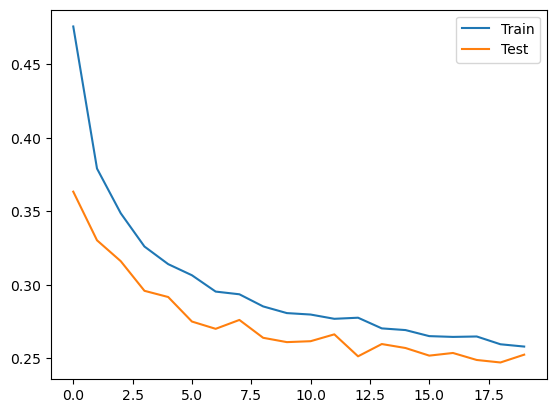

In [12]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend();


In [13]:
# save scaler
with open(output_path+'/model_y_scaler.pkl', 'wb') as f:
    pickle.dump(scalery, f)
